## Import requirements & Parameters setting

In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import glob
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input, Conv1D, ReLU
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.functions import checkDirExist, deleteDir

batch_size = 32
epochs = 300

# set model name & model directory
model_name = '20201209_cnn-rmse-position5-trajectory2-100-diff-euclidean-conv1D-64-128-256-128-64'
model_dir = os.path.join(os.getcwd(), 'models/'+model_name)
log_dir = os.path.join(os.getcwd(), 'logs/'+model_name)
checkDirExist(model_dir)

# get train data (csv)
train_dir = os.path.join(os.getcwd(), 'dataset/position_5/trajectory-100-padding/dataset-2/train/')
train_list = glob.glob(train_dir + "*.csv")

# split validation
random.Random(4).shuffle(train_list)
vaild_num = int(len(train_list)*0.1)
valid_list = train_list[:vaild_num]
train_list = train_list[vaild_num:]

# get test data (csv)
test_dir = os.path.join(os.getcwd(), 'dataset/position_5/trajectory-100-padding/dataset-2/test/')
test_list = glob.glob(test_dir + "*.csv")

print('train: ', len(train_list))
print('valid: ', len(valid_list))
print('test: ', len(test_list))

Using TensorFlow backend.


The directory is deleted successfully
train:  755
valid:  83
test:  386


## Dynamic allocation for GPU (optional)

In [2]:
import keras.backend.tensorflow_backend as KTF

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True   # Dynamic allocation
sess = tf.Session(config=config)
KTF.set_session(sess)

## Train / Validation / Test generator definition

In [3]:
def train_generator():
    while(True):
        random.Random(4).shuffle(train_list)
        for i, csv in enumerate(train_list):
            df = pd.read_csv(csv)
            data = []
            diff = []
            for idx in df.index:
                diff.append(df.loc[idx, ['X', 'Y']].tolist())
            label = df.loc[0, ['Speed', 'Angle_H', 'Angle_V']].tolist()

            diff = np.diff(np.array(diff), axis=0).tolist()  # compute diff
            for idx, (x, y) in enumerate(diff):
                if x == 0 and y == 0:
                    diff[idx-1] = [0, 0]
            for idx, diff in enumerate(diff):
                data.append(diff)  # diff
                data[idx].append(np.linalg.norm(diff))  # Euclidean distance
            
            x_train = np.expand_dims(data, axis=0)
            y_train = np.expand_dims(np.array(label), axis=0)

            y_train = y_train.astype(np.float32)
            y_train[:, 0] = (y_train[:, 0]-20)/120
            y_train[:, 1] = (y_train[:, 1]-10)/60
            y_train[:, 2] = (y_train[:, 2]-10)/30

            yield x_train, y_train, [None]

In [4]:
def valid_generator():
    while(True):
        for i, csv in enumerate(valid_list):
            df = pd.read_csv(csv)
            data = []
            diff = []
            for idx in df.index:
                diff.append(df.loc[idx, ['X', 'Y']].tolist())
            label = df.loc[0, ['Speed', 'Angle_H', 'Angle_V']].tolist()

            diff = np.diff(np.array(diff), axis=0).tolist()  # compute diff
            for idx, (x, y) in enumerate(diff):
                if x == 0 and y == 0:
                    diff[idx-1] = [0, 0]
            for idx, diff in enumerate(diff):
                data.append(diff)  # diff
                data[idx].append(np.linalg.norm(diff))  # Euclidean distance
            
            x_valid = np.expand_dims(data, axis=0)
            y_valid = np.expand_dims(np.array(label), axis=0)

            y_valid = y_valid.astype(np.float32)
            y_valid[:, 0] = (y_valid[:, 0]-20)/120
            y_valid[:, 1] = (y_valid[:, 1]-10)/60
            y_valid[:, 2] = (y_valid[:, 2]-10)/30

            yield x_valid, y_valid, [None]

In [5]:
def test_generator():
    for i, csv in enumerate(test_list):
        df = pd.read_csv(csv)
        data = []
        diff = []
        for idx in df.index:
            diff.append(df.loc[idx, ['X', 'Y']].tolist())
        label = df.loc[0, ['Speed', 'Angle_H', 'Angle_V']].tolist()

        diff = np.diff(np.array(diff), axis=0).tolist()  # compute diff
        for idx, (x, y) in enumerate(diff):
                if x == 0 and y == 0:
                    diff[idx-1] = [0, 0]
        for idx, diff in enumerate(diff):
            data.append(diff)  # diff
            data[idx].append(np.linalg.norm(diff))  # Euclidean distance

        x_test = np.expand_dims(data, axis=0)
        y_test = np.expand_dims(np.array(label), axis=0)
        split_percentage = csv.split('predict_')[1].split('.csv')[0]

        x_test = x_test.astype(np.float32)
        y_test = y_test.astype(np.float32)
        yield x_test, y_test, [None]

## Build model

In [6]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [7]:
model = Sequential()
model.add(Conv1D(64, 3, input_shape=(56, 3)))
model.add(ReLU())
model.add(Conv1D(128, 3))
model.add(ReLU())
model.add(Conv1D(256, 3))
model.add(ReLU())
model.add(Conv1D(128, 3))
model.add(ReLU())
model.add(Conv1D(64, 3))
model.add(ReLU())
model.add(Flatten())
model.add(Dense(3))
model.add(ReLU())

model.compile(loss=root_mean_squared_error, optimizer="adam", metrics=['mae'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 54, 64)            640       
_________________________________________________________________
re_lu (ReLU)                 (None, 54, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 52, 128)           24704     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 52, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 256)           98560     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 50, 256)           0         
_________________________________________________________________
conv

In [8]:
from tensorflow.keras.utils import plot_model
plot_file = os.path.join(model_dir, model_name+'.png')
plot_model(model, show_shapes=True, show_layer_names=True, to_file=plot_file)

In [9]:
# save training logs
log_dir = os.path.join(os.getcwd(), 'logs')
model_cbk = keras.callbacks.TensorBoard(log_dir="logs/{}".format(model_name), histogram_freq=1)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

# save best model weights
model_mckp = keras.callbacks.ModelCheckpoint(os.path.join(model_dir, model_name+".h5"), 
                                             monitor='val_loss', 
                                             save_best_only=True, 
                                             mode='min')

In [10]:
history = model.fit(train_generator(), 
                    steps_per_epoch=batch_size, 
                    epochs=epochs, 
                    validation_data=valid_generator(),
                    validation_steps=len(valid_list),
                    callbacks=[model_mckp, model_cbk])

Epoch 1/300
32/32 [==============================] - 8s 248ms/step - loss: 0.6096 - mean_absolute_error: 0.5201 - val_loss: 0.5269 - val_mean_absolute_error: 0.4583
Epoch 2/300
32/32 [==============================] - 6s 180ms/step - loss: 0.4524 - mean_absolute_error: 0.3991 - val_loss: 0.3659 - val_mean_absolute_error: 0.3097
Epoch 3/300
32/32 [==============================] - 6s 180ms/step - loss: 0.3946 - mean_absolute_error: 0.3321 - val_loss: 0.3924 - val_mean_absolute_error: 0.3372
Epoch 4/300
32/32 [==============================] - 6s 195ms/step - loss: 0.3989 - mean_absolute_error: 0.3278 - val_loss: 0.4263 - val_mean_absolute_error: 0.3576
Epoch 5/300
32/32 [==============================] - 7s 218ms/step - loss: 0.4023 - mean_absolute_error: 0.3457 - val_loss: 0.3242 - val_mean_absolute_error: 0.2635
Epoch 6/300
32/32 [==============================] - 6s 190ms/step - loss: 0.3452 - mean_absolute_error: 0.2769 - val_loss: 0.3373 - val_mean_absolute_error: 0.2756
Epoch 7/30

## Load model (optional)

In [11]:
'''
# Load model
model_dir = "models/20201202_lstm-rmse-position5-trajectory2-100-diff-euclidean-32-8/"
model_name = "20201202_lstm-rmse-position5-trajectory2-100-diff-euclidean-32-8.h5"
model_path = os.path.join(model_dir, model_name)
model = keras.models.load_model(model_path,
                                custom_objects={'root_mean_squared_error': root_mean_squared_error})

# eval_his = model.evaluate_generator(test_generator(), steps=len(test_list), verbose=1)
'''

'\n# Load model\nmodel_dir = "models/20201202_lstm-rmse-position5-trajectory2-100-diff-euclidean-32-8/"\nmodel_name = "20201202_lstm-rmse-position5-trajectory2-100-diff-euclidean-32-8.h5"\nmodel_path = os.path.join(model_dir, model_name)\nmodel = keras.models.load_model(model_path,\n                                custom_objects={\'root_mean_squared_error\': root_mean_squared_error})\n\n# eval_his = model.evaluate_generator(test_generator(), steps=len(test_list), verbose=1)\n'

## Model evaluate

In [ ]:
# Predict
predict = model.predict_generator(test_generator(), verbose=1, steps=len(test_list))

predict[:, 0] = predict[:, 0] * 120 + 20
predict[:, 1] = predict[:, 1] * 60 + 10
predict[:, 2] = predict[:, 2] * 30 + 10

# Present as dataframe
df = pd.DataFrame()
for i, (_, y_test, split_percentage) in enumerate(test_generator()):
    df.loc[i, 'Speed'] = y_test[:, 0]
    df.loc[i, 'Angle_H'] = y_test[:, 1]
    df.loc[i, 'Angle_V'] = y_test[:, 2]
#     df.loc[i, 'split'] = split_percentage
    df.loc[i, 'Predict(Speed)'] = predict[:,0][i]
    df.loc[i, 'Predict(Angle_H)'] = predict[:,1][i]
    df.loc[i, 'Predict(Angle_V)'] = predict[:,2][i]

# Adjust data type
df = df.astype({'Speed': 'int32',
                'Angle_H': 'int32',
                'Angle_V': 'int32',
                'Predict(Speed)': 'int32',
                'Predict(Angle_H)': 'int32',
                'Predict(Angle_V)': 'int32'})

# Caculate Loss
for i in df.index:
    target = df.loc[i, ['Speed', 'Angle_H', 'Angle_V']].tolist()
    target[0] = (target[0]-20)/120
    target[1] = (target[1]-10)/60
    target[2] = (target[2]-10)/30
    pred = df.loc[i, ['Predict(Speed)', 'Predict(Angle_H)', 'Predict(Angle_V)']].tolist()
    pred[0] = (pred[0]-20)/120
    pred[1] = (pred[1]-10)/60
    pred[2] = (pred[2]-10)/30
    
    mae = mean_absolute_error(target, pred)
    rmse = np.sqrt(mean_squared_error(target, pred))
    df.loc[i, 'MAE'] = np.around(mae, decimals=6)
    df.loc[i, 'RMSE'] = np.around(rmse, decimals=6)

df.sort_values("Speed", inplace=True)
df

## Save evaluate results

In [12]:
# Caculate mean loss
last_idx = len(df)
df.loc[last_idx, 'MAE'] = df['MAE'].mean()
df.loc[last_idx, 'RMSE'] = df['RMSE'].mean()

# Save result to csv
result_dir = os.path.join(os.getcwd(), 'predictions/')
checkDirExist(result_dir)
df.to_csv(os.path.join(result_dir, model_name+'.csv'), index=False)

## Plot history

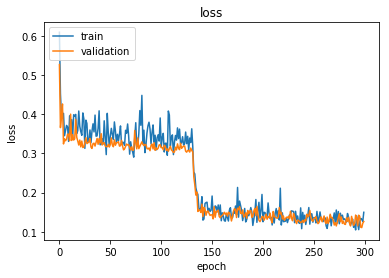

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

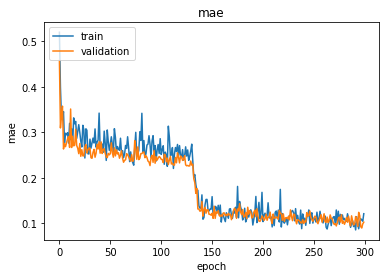

In [14]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Convert Jupyter(.ipynb) to Python(.py) (optional)

In [16]:
# jupyter nbconvert --to script cnn_regression_rmse_trajectory.ipynb